# Contents <a id='top'></a>

1. <a href=#intro>Introduction</a>
1. <a href=#pre-proc>NLP Pre-processing</a>
1. <a href=#bow>Bag of Words Model</a>
1. <a href=#lda>Topic Modeling</a>
1. <a href=#senti>Sentiment Analysis</a>
1. <a href=#ref>References and Links</a>

<a id='intro'></a>
# 1. Introduction
<a href=#top>(back to top)</a>

In our world, Natural Language Processing (NLP) is used in several scenarios. For example, 

    * phones and handheld computers support predictive text and handwriting recognition; 
    * web search engines give access to information locked up in unstructured text; 
    * machine translation allows us to understand texts written in languages that we do not know; 
    * text analysis enables us to detect sentiment in tweets and blogs.

But as we begin to explore Natural Language, we realise that it is an extremely difficult subject. Here are some specific points to note:

1. Some words mean different things in different contexts, but us humans know which meaning is being used.
    * He **served** the **dish**.
1. In the following two sentences, the word "by" has different meanings:
    * The lost children were found by the lake.
    * The lost children were found by the search party.
1. In the following cases, we (humans) can resolve what "they" is referring to, but it is not easy to generate a simple rule that a computer can follow.
    * The thieves stole the paintings. They were subsequently recovered.
    * The thieves stole the paintings. They were subsequently arrested.
1. How can we get a computer to understand the following tweet?:
    * "Wow. Great job st@rbuck's. Best cup of coffee ever."

## Definitions

Before we go on, it would be useful to establish some terminology.

A *document* is a string of text. It could contain an essay on a particular topic, a paragraph, a single sentence, or even just a tweet of 140 characters. 

A *text corpus* is a large collection of text documents. The plural of corpus is *corpora*. 

Each document is typically split into *tokens* before the actual NLP is done. Consider the sentence

A typical *tokenisation* would be 

How we tokenize and pre-process things will affect our final results. We shall discuss this more in a minute.

## Goals of NLP

Corpora could come in different formats and have different structures.

![text-corpus-structure](../figs/text-corpus-structure_nlp.png)

Sometimes, the format or relationships between the documents in a corpus restrict or direct us toward certain types of analyses. In general, the goals of NLP can be varied. Here are some of the use-cases that we shall discuss:

1. *Computing similarities between new documents and existing ones in a corpus*. This is an unsupervised approach. If the new document can be considered a "query", then this can be used to retrieve and prioritise documents that are relevant to the query.
2. *Identifying "topics" within a corpus*. This is also an unsupervised technique, and allows us to identify the salient topics of a new document automatically. This could be useful in a customer feedback setting, because it would allow quick allocation or prioritisation of resources. This approach requires one to decide on the number of topics. It typically also requires some study of the topics in order to interpret and verify them.
3. *Identifying the overarching sentiment of a document*. Using a lexicon of words and their tagged sentiments, we can assess whether the sentiment in a document is mostly positive or negative.

There are some other applications and ideas that we may not have time to cover:

1. *Named Entity Recognition* If we can identify the particular real-world entities that a query is referring to, we would be able to provide more accurate answers from the corpus. This concept is utilised in chatbots.
2. *Word Embeddings*. This procedure provides a vector representation of a word, in the context of its semantic usage. With this, we can study the context of a word in this corpus, and understand what it means here.

# Wine Reviews Dataset

A dataset containing wine reviews is accessible from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews). We shall work with one of the csv files. It contains 130,000 rows. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
wine_reviews = pd.read_csv("../data/winemag-data-130k-v2.csv", index_col=0)

In [3]:
wine_reviews

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


Index of first occurance. 

In [4]:
np.where(wine_reviews.duplicated(subset=None, keep='last') == True)

(array([     9,     10,     11, ..., 126999, 127000, 127001]),)

Index of lase occurance.

In [5]:
np.where(wine_reviews.duplicated(subset=None, keep='first') == True)

(array([  2408,   2409,   2410, ..., 129881, 129882, 129913]),)

In [6]:
wine_reviews[wine_reviews.description == wine_reviews.description[2408]]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
56,US,"This is weighty, creamy and medium to full in ...",NaN,85,14.0,California,North Coast,North Coast,Virginie Boone,@vboone,Souverain 2010 Chardonnay (North Coast),Chardonnay,Souverain
2408,US,"This is weighty, creamy and medium to full in ...",NaN,85,14.0,California,North Coast,North Coast,Virginie Boone,@vboone,Souverain 2010 Chardonnay (North Coast),Chardonnay,Souverain


Check number of rows that's duplicated.

In [7]:
np.sum(wine_reviews.duplicated())

9983

In [8]:
wine_reviews.drop_duplicates(inplace=True)

Number of reviews left over.

In [9]:
wine_reviews.shape

(119988, 13)

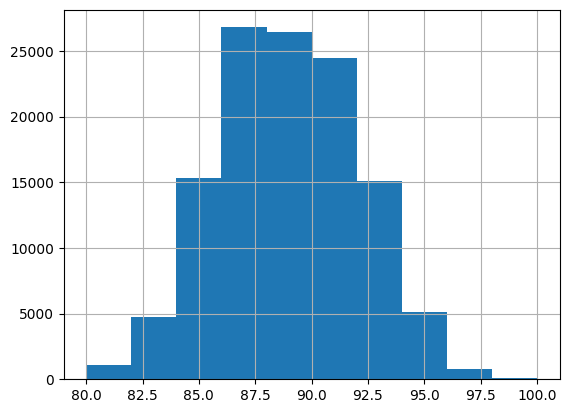

In [10]:
wine_reviews.points.hist();

In [11]:
wine_reviews.description.values[:5]

array(["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
       "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
       'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.',
       'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.',
       "Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it

The "descriptions" column contains the review for a particular wine by a user, whose name and twitter handle are provided. Also included is information such as the price, originating county, region of the wine, and so on. In our activity, we are going to apply NLP techniques to the wine reviews.

<a id='pre-proc'></a>
# 2. NLP Pre-Processing
<a href=#top>(back to top)</a>

Text documents consist of sentences of varying lengths. Usually, the first step to analysing a document is to break it up into pieces. This process is known as **tokenizing**. When tokenizing a document, we can do it at several levels of resolution: at the sentence, line, word or even punctuation level.

For today, we are going to to simply tokenize each document by whitespace. This is easily done using `.split()` within built-in Python. But after that, we need to further pre-process the tokens.

In [12]:
from gensim.parsing.preprocessing import *
from gensim import models, corpora, similarities
from gensim.models.coherencemodel import CoherenceModel
import pprint

pp = pprint.PrettyPrinter(indent=4, compact=True,)

The `gensim` package includes a module for pre-processing text strings. Here is a list of some of the functions there:

* `strip_multiple_whitespaces`
* `strip_non_alphanum`
* `strip_numeric`
* `strip_punctuation`
* `strip_short`

Remove frequently occuring "noise" so "signal" will not be drowned out.

In [13]:
r1 = wine_reviews.description.values[0]

In [14]:
pp.pprint(r1.lower().split())

[   'aromas', 'include', 'tropical', 'fruit,', 'broom,', 'brimstone', 'and',
    'dried', 'herb.', 'the', 'palate', "isn't", 'overly', 'expressive,',
    'offering', 'unripened', 'apple,', 'citrus', 'and', 'dried', 'sage',
    'alongside', 'brisk', 'acidity.']


In [15]:
pp.pprint(strip_punctuation(r1.lower()).split())

[   'aromas', 'include', 'tropical', 'fruit', 'broom', 'brimstone', 'and',
    'dried', 'herb', 'the', 'palate', 'isn', 't', 'overly', 'expressive',
    'offering', 'unripened', 'apple', 'citrus', 'and', 'dried', 'sage',
    'alongside', 'brisk', 'acidity']


In [16]:
sent1 = 'This contains a number 144.'

In [17]:
pp.pprint(strip_numeric(sent1.lower()).split())

['this', 'contains', 'a', 'number', '.']


Since what we are about to do in the initial part of our activity is based on frequency counts of tokens, apart from some of the above steps, we are also going to remove common "filler" words that could end up skewing the eventual probability distributions of counts. These filler words are known as *stop words*. Linguists came up with them. They vary from model to model, from Python package to package, and of course, from language to language.

It depends on your particular application if stop-word removal is meaningful or not. At times, it is only done in order to speed up the training of a model. However, it is possible to change the entire meaning of a sentence by removing stop-words.

In [18]:
s1 = 'I do not like eating ice cream.'

In [19]:
remove_stopwords(s1).split()

['I', 'like', 'eating', 'ice', 'cream.']

In [20]:
#pp.pprint(STOPWORDS)

For us, we are going to apply this list of filters to each review:

1. strip_punctuation(),
2. strip_multiple_whitespaces(),
3. strip_numeric(),
4. remove_stopwords(),
5. strip_short(),
6. lemmatize

Lemmatizing a word is to reduce it to its root word. You will come across stemming whenever you read about lemmatizing. In both cases, we wish to reduce a word to its root word so that we do not have to deal with multiple variations of a token, such as ate, eating, and eats.

When we stem a word, the prefix and/or suffix will be removed according to a set of rules. Since it is primarily rule-based, the resulting word may not be an actual English word.

Like stemming, lemmatizing also aims to reduce a word to its root form. However, it differs from stemming in that the final word must be a proper English language word. For this purpose, the algorithm has to be supplied with a lexicon or dictionary, along with the text to be lemmatized.

Here is an example that demonstrates the differences.

In [21]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter = PorterStemmer()
wn = WordNetLemmatizer()

demo_sentence = 'Cats and ponies have a meeting'.split()

In [22]:
demo_sentence

['Cats', 'and', 'ponies', 'have', 'a', 'meeting']

In [23]:
[porter.stem(x) for x in demo_sentence]

['cat', 'and', 'poni', 'have', 'a', 'meet']

In [24]:
# import nltk
# nltk.download('omw-1.4')
# nltk.download('wordnet')
[wn.lemmatize(x) for x in demo_sentence]

['Cats', 'and', 'pony', 'have', 'a', 'meeting']

Now let us go ahead and perform the pre-processing on the wine reviews.

In [25]:
CUSTOM_FILTER = [lambda x: x.lower(), strip_punctuation, 
                 strip_multiple_whitespaces, strip_numeric, 
                 remove_stopwords, strip_short]

In [26]:
all_review_strings = wine_reviews.description.values

In [27]:
all_strings_tokenized = [preprocess_string(x, CUSTOM_FILTER) for x in all_review_strings]

In [28]:
pp.pprint(all_strings_tokenized[1])

[   'ripe', 'fruity', 'wine', 'smooth', 'structured', 'firm', 'tannins',
    'filled', 'juicy', 'red', 'berry', 'fruits', 'freshened', 'acidity',
    'drinkable', 'certainly', 'better']


We prefer lemmatization over stemming. Lemmatization gives better resultant word as it gives the root word.

At this point in time, what we have is a list of lists. Each sub-list contains the tokens for a particular wine_review. For instance, the original review for row 234 was:

In [29]:
pp.pprint(wine_reviews.description.values[233])

('There is an odd, piercing edge to the aromas, a mix of acetic acid and '
 "pungent herb, with a hint of diesel. Somehow it's not off-putting, just "
 'atypical. The light, tart fruit is a mix of rhubarb and cranberry, very '
 'earthy and tasting of dirt and bark in the finish. This could be quite '
 'pleasant with a hearty, rustic dish such as beef Bourgogne.')


In [30]:
pp.pprint(all_strings_tokenized[233])

[   'odd', 'piercing', 'edge', 'aromas', 'mix', 'acetic', 'acid', 'pungent',
    'herb', 'hint', 'diesel', 'putting', 'atypical', 'light', 'tart', 'fruit',
    'mix', 'rhubarb', 'cranberry', 'earthy', 'tasting', 'dirt', 'bark',
    'finish', 'pleasant', 'hearty', 'rustic', 'dish', 'beef', 'bourgogne']


`gensim` does not have a lemmatizer, so we use the nltk lemmatizer on each token.

In [31]:
preprocessed_corpus = [[wn.lemmatize(w) for w in dd ] for dd in all_strings_tokenized]

In [32]:
pp.pprint(preprocessed_corpus[10])

[   'soft', 'supple', 'plum', 'envelope', 'oaky', 'structure', 'cabernet',
    'supported', 'merlot', 'coffee', 'chocolate', 'complete', 'picture',
    'finishing', 'strong', 'end', 'resulting', 'value', 'priced', 'wine',
    'attractive', 'flavor', 'immediate', 'accessibility']


In [33]:
pp.pprint(all_strings_tokenized[10])

[   'soft', 'supple', 'plum', 'envelopes', 'oaky', 'structure', 'cabernet',
    'supported', 'merlot', 'coffee', 'chocolate', 'complete', 'picture',
    'finishing', 'strong', 'end', 'resulting', 'value', 'priced', 'wine',
    'attractive', 'flavor', 'immediate', 'accessibility']


<a id='bow'></a>
# 3. Tfidf Model (Bag-of-Words)
<a href=#top>(back to top)</a>

In order to perform machine learning on text documents, we have to convert the text content into numerical features. The first method we shall study is to use the Bag of Words (BoW) representation. Here's how it is done, starting from a corpus:

1. Build a vocabulary of words from the corpus and assign a fixed integer id to each word.
2. For each document $i$ in the collection, count the number of occurrences of word $j$ in the dictionary.
3. Store this count in the $(i,j)$-th entry of a matrix.

At this point we have a numerical representation of the corpus. Let us take a look at a simple example instead of the wine review one.

In [34]:
raw_docs = ["Here are some very simple basic sentences.",
            "So basic that they won’t be very interesting , I’m afraid. ", 
            """The point of these basic examples is to learn how basic text 
            counting works on *very simple* data, so that we are not afraid when 
            it comes to larger text documents. The sentences are here just to provide words."""]

In [35]:
raw_docs[2]

'The point of these basic examples is to learn how basic text \n            counting works on *very simple* data, so that we are not afraid when \n            it comes to larger text documents. The sentences are here just to provide words.'

We apply the default pre-processing filters from gensim and inspect the tokens now.

In [36]:
example_corpus = preprocess_documents(raw_docs)

In [37]:
pp.pprint(example_corpus)

[   ['simpl', 'basic', 'sentenc'],
    ['basic', 'won’t', 'interest', 'i’m', 'afraid'],
    [   'point', 'basic', 'exampl', 'learn', 'basic', 'text', 'count', 'work',
        'simpl', 'data', 'afraid', 'come', 'larger', 'text', 'document',
        'sentenc', 'provid', 'word']]


In what proceeds, we build a vocabulary of terms in the corpus, and convert them to the Bag of Words representation.

In [38]:
d1 = corpora.Dictionary(example_corpus)

In [39]:
d1

In [40]:
d1[17]

'word'

In [41]:
pp.pprint(list(d1.items()))

[   (0, 'basic'), (1, 'sentenc'), (2, 'simpl'), (3, 'afraid'), (4, 'interest'),
    (5, 'i’m'), (6, 'won’t'), (7, 'come'), (8, 'count'), (9, 'data'),
    (10, 'document'), (11, 'exampl'), (12, 'larger'), (13, 'learn'),
    (14, 'point'), (15, 'provid'), (16, 'text'), (17, 'word'), (18, 'work')]


In [42]:
print(d1)

Dictionary<19 unique tokens: ['basic', 'sentenc', 'simpl', 'afraid', 'interest']...>


In [43]:
d1.token2id['basic']

0

In [44]:
d1.id2token[16]

'text'

In [45]:
example_bow = [d1.doc2bow(x) for x in example_corpus]
pp.pprint(example_bow)

[   [(0, 1), (1, 1), (2, 1)], [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
    [   (0, 2), (1, 1), (2, 1), (3, 1), (7, 1), (8, 1), (9, 1), (10, 1),
        (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1),
        (18, 1)]]


Now, we have a sparse representation of each document in our corpus. We can in fact convert it back to the processed corpus mode at any time.

The counts indicate the number of times each feature (or words) were present in the document. As you might observe, longer documents tend to contain larger counts (see document 3, which has many more 1's and even a couple of 2's. Thus, instead of dealing with counts, 
we shall convert each row into a vector of length 1. Words that appear in all documents will be weighted down by this transformation, since these do not help to distinguish the document from others. This transformation is known as the TF-IDF transformation.

Instead of the raw counts, we define:

* $N$ to be the number of documents ($N=3$ in the little example above).
* $tf_{i,j}$ to be the frequency of term $i$ in document $j$.
* $df_{i}$ to be the frequency of term $i$ across all documents.
* $w'_{i,j}$ to be: 

\begin{equation}
w'_{i,j} = tf_{i,j} \times \log_2 \left( \frac{N}{df_{i}} \right)
\end{equation}

Then the final $w_{i,j}$ for term $i$ in document $j$ is the normalised version of $w'_{i,j}$ across the terms in that document. 

Consider the word "sentences", in document id 02 (the third document).
* $N = 3$
* $tf_{i,j} = 1$
* $df_{i} = 2$

Thus

\begin{equation}
w'_{ij} = 1 \times \log_2 ( 3/2) = 0.58
\end{equation}

to be useful, need to change w'ij to wij, which is the normalised form of w'ij.    
wij = w'ij/|sqrt(sum((w'ij)^2)|   

In [79]:
example_tfidf = models.TfidfModel(example_bow, normalize=False)

In [49]:
example_bow[0]

[(0, 1), (1, 1), (2, 1)]

## When normalising, it against the entire document collection? Or is it in that corpus only? 

return the weights for tfidf bag of word at position 0

In [50]:
pp.pprint(example_tfidf[example_bow[0]])

[(1, 0.5849625007211562), (2, 0.5849625007211562)]


In [55]:
pp.pprint(example_tfidf[example_bow[1]])

[   (3, 0.5849625007211562), (4, 1.5849625007211563), (5, 1.5849625007211563),
    (6, 1.5849625007211563)]


In [56]:
pp.pprint(example_tfidf[example_bow[2]])

[   (1, 0.5849625007211562), (2, 0.5849625007211562), (3, 0.5849625007211562),
    (7, 1.5849625007211563), (8, 1.5849625007211563), (9, 1.5849625007211563),
    (10, 1.5849625007211563), (11, 1.5849625007211563),
    (12, 1.5849625007211563), (13, 1.5849625007211563),
    (14, 1.5849625007211563), (15, 1.5849625007211563),
    (16, 3.1699250014423126), (17, 1.5849625007211563),
    (18, 1.5849625007211563)]


In [51]:
pp.pprint(example_bow[0])

[(0, 1), (1, 1), (2, 1)]


In [53]:
example_bow[1]

[(0, 1), (3, 1), (4, 1), (5, 1), (6, 1)]

In [54]:
example_bow[2]

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1)]

In [52]:
pp.pprint(example_tfidf[d1.doc2bow(['basic', 'afraid', 'data'])])

[(3, 0.5849625007211562), (9, 1.5849625007211563)]


Now let us move back to the wine reviews and create the tfidf transform.

In [57]:
dct = corpora.Dictionary(preprocessed_corpus)

In [58]:
list(dct.items())[-1]

(31830, 'krause')

In [59]:
dct.dfs[31830]

1

In [60]:
np.log2(119988/31325)

1.9375037144559755

In [61]:
#dct.num_docs
bow_corpus = [dct.doc2bow(text) for text in preprocessed_corpus]

In [62]:
pp.pprint(bow_corpus[0])

[   (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2),
    (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1),
    (17, 1), (18, 1), (19, 1)]


In [63]:
pp.pprint(preprocessed_corpus[0])

[   'aroma', 'include', 'tropical', 'fruit', 'broom', 'brimstone', 'dried',
    'herb', 'palate', 'isn', 'overly', 'expressive', 'offering', 'unripened',
    'apple', 'citrus', 'dried', 'sage', 'alongside', 'brisk', 'acidity']


In [64]:
tfidf = models.TfidfModel(dictionary=dct)

.doc2bow ==> feed 

In [65]:
pp.pprint(tfidf[dct.doc2bow(preprocessed_corpus[0])])
#pp.pprint(tfidf[bow_corpus[0]])

[   (0, 0.06268421784699893), (1, 0.14974508293522842), (2, 0.1052742031026895),
    (3, 0.05486348650362946), (4, 0.35883356871086886),
    (5, 0.19276437299529803), (6, 0.30616173997651897), (7, 0.1146637303460399),
    (8, 0.2679070243551733), (9, 0.2496099750302706), (10, 0.03993042791710815),
    (11, 0.11697054700080736), (12, 0.24584250178188813),
    (13, 0.24816130465597763), (14, 0.18222341765984254),
    (15, 0.2564656935097344), (16, 0.05825113530972409),
    (17, 0.201809456382074), (18, 0.16626545281578367),
    (19, 0.49459995465236584)]


Vector here is unit length. (Unit vector)  
Only none 0 term frequency is shown. 

In [66]:
# Unspect token 19 as it is large
# 19 is the word "unripened"

### Purpose ==> find similarity of new document compared with current documents

Before we can find matching documents, we build a similarity index, so that matches are returned quicker. We try something simple at first:

> Which documents/reviews are similar to the first one?

In [67]:
index = similarities.Similarity(None, corpus=tfidf[bow_corpus], num_features=len(dct))

In [68]:
sims = index[tfidf[bow_corpus[0]]]

In [70]:
sims.shape

(119988,)

In [69]:
sims

array([1.0000001 , 0.00812111, 0.00441876, ..., 0.        , 0.02309647,
       0.00208725], dtype=float32)

These are the most similar reviews to review id 0. Of course, the first review itself is there!

In [71]:
# Find the 10 most similar documents to document 0
np.argsort(-sims)[:10]

array([     0, 108537,   2000,   9929,   9936,  28448,  35689,  49079,
       102482,  25705])

In [72]:
pp.pprint(wine_reviews.description[[0, 108537, 2000, 9929]].values)

array(["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
       'Densely tannic and rich, this is full of ripe chocolate and blackberry fruit. It is dark, brooding and dense—a great success for the second wine of Château du Glana.',
       "The nose isn't very expressive but reveals white flower and tropical fruit. The simple palate delivers pineapple and lemon zest alongside brisk acidity.",
       'From a top subsection of McLaren Vale, this well-crafted Shiraz features a nice balance of sweet and savory notes. Ripe blackberry and plum flavors are matched by nuances of cedar, spice and meat. This creamy-textured Shiraz seems to be already approaching maturity; drink it now through 2012.'],
      dtype=object)


In [73]:
wine_reviews.loc[[0, 108537, 2000, 9929], :]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
108537,France,"Densely tannic and rich, this is full of ripe ...",Terre du Lion,90,64.0,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château du Glana 2009 Terre du Lion (Saint-Ju...,Bordeaux-style Red Blend,Château du Glana
2000,Italy,The nose isn't very expressive but reveals whi...,Baglio del Sole,84,12.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Feudi del Pisciotto 2013 Baglio del Sole Inzol...,Inzolia,Feudi del Pisciotto
9929,Australia,"From a top subsection of McLaren Vale, this we...",Angel Gully,90,50.0,South Australia,Clarendon,NaN,Joe Czerwinski,@JoeCz,Joseph 2003 Angel Gully Shiraz (Clarendon),Shiraz,Joseph


In [ ]:
#sims = index[tfidf[bow_corpus[20]]]

Now let us try an arbitrary query. Suppose we are interested in "fruity full palate" wines.

In [74]:
q1 = 'acidic oaky chardonnay'.split()
q1

['acidic', 'oaky', 'chardonnay']

In [75]:
sims = index[tfidf[dct.doc2bow(q1)]]

In [76]:
q1_results = np.argsort(-sims)[:10]
q1_results

array([  3971,  84197,  12031,  47036,  89276, 102148,   3655,  14083,
        66227,  84069])

In [77]:
pp.pprint(wine_reviews.description.values[q1_results])

array(['A nice wine, good and dry. It has forward peach, pineapple, apricot and oaky vanilla and caramel flavors, and a finely acidic finish.',
       'A standard Chardonnay, dry and nicely acidic, with citrus, pear, vanilla, lees and oak flavors.',
       'Dry and acidic, this Chardonnay has a herbaceous earthiness, plus flavors of orange and pear.',
       'A heavy, oaky Chardonnay whose tropical fruit and vanilla flavors are dull.',
       'This is thin and acidic, with flavors of sour cherry candy and spice.',
       'This is acidic and sweet, with a medicinal taste.',
       "Oaky and strong in jammy fruit, this Chardonnay has potent pineapple, tropical fruit and buttered caramel popcorn flavors. It's also quite acidic. Would benefit from greater control and nuance.",
       'Dry and oaky, this Chardonnay offers herb-inflected pineapple and pear flavors.',
       "Dry, acidic, oaky, it'also a little herbaceous. Orange and mango flavors are enhanced with plenty of oak. While it's e

In [78]:
wine_reviews.iloc[q1_results, :]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
3981,US,"A nice wine, good and dry. It has forward peac...",NaN,85,20.0,California,Russian River Valley,Sonoma,NaN,NaN,Bearboat 2004 Chardonnay (Russian River Valley),Chardonnay,Bearboat
88912,US,"A standard Chardonnay, dry and nicely acidic, ...",NaN,84,14.0,California,Russian River Valley,Sonoma,NaN,NaN,Adler Fels 2010 Chardonnay (Russian River Valley),Chardonnay,Adler Fels
12082,US,"Dry and acidic, this Chardonnay has a herbaceo...",Orchard Vineyard,86,40.0,California,Napa Valley,Napa,NaN,NaN,Shadowbox 2010 Orchard Vineyard Chardonnay (Na...,Chardonnay,Shadowbox
48365,US,"A heavy, oaky Chardonnay whose tropical fruit ...",NaN,82,23.0,California,Santa Barbara County,Central Coast,NaN,NaN,Frisby 2009 Chardonnay (Santa Barbara County),Chardonnay,Frisby
94595,US,"This is thin and acidic, with flavors of sour ...",Nicky Hahn,82,14.0,California,Central Coast,Central Coast,NaN,NaN,Hahn 2011 Nicky Hahn G-S-M (Central Coast),G-S-M,Hahn
109225,US,"This is acidic and sweet, with a medicinal taste.",Hayley Vineyard,80,36.0,California,Anderson Valley,NaN,NaN,NaN,Bryter 2009 Hayley Vineyard Pinot Noir (Anders...,Pinot Noir,Bryter
3665,US,"Oaky and strong in jammy fruit, this Chardonna...",NaN,84,25.0,California,Sonoma Coast,Sonoma,NaN,NaN,Crossbarn by Paul Hobbs 2009 Chardonnay (Sonom...,Chardonnay,Crossbarn by Paul Hobbs
14178,US,"Dry and oaky, this Chardonnay offers herb-infl...",NaN,86,60.0,California,Napa Valley,Napa,NaN,NaN,Patland 2011 Chardonnay (Napa Valley),Chardonnay,Patland
69191,US,"Dry, acidic, oaky, it'also a little herbaceous...",Estate Grown,87,32.0,California,Oak Knoll District,Napa,NaN,NaN,Monticello Vineyards 2012 Estate Grown Chardon...,Chardonnay,Monticello Vineyards
88771,US,"A vibrantly acidic, fresh young Chardonnay, cl...",NaN,87,33.0,California,Sonoma Coast,Sonoma,NaN,NaN,Bartz-Allen 2009 Chardonnay (Sonoma Coast),Chardonnay,Bartz-Allen


<a id='lda'></a>
# 4. Topic Modeling
<a href=#top>(back to top)</a>

The LDA (Latent Dirichlet Allocation) model assumes the following intuitive generative process for the documents:

Thinking of topics as distribution of vocabulary.   
each topic is a porobability distrubution of those tokens identified in bag of words.  
Topics differ in their probability distribution.  
---
### Each topic should be viewed as the probability distribution on the entire vocabulary.  
### The same word can have a different probability under different topic.
### each document can be viewed as a probability distribution on topics.  
### Bayes????
---

1. There is a set of $K$ topics that the documents come from. Each document contains words from several topics. There is a probability mass function on the topics for each document.
2. For each topic, there is a probability mass function for the distribution of words in that topic. 

At the end of LDA topic modeling, we will be able to tell, for a particular (new or old) document: the weight combination of the topics for that document. For each topic, we would be able to tell the terms that are salient.

LDA only gives us the probabilistic weights &mdash; we have to interpret them ourselves.

In [80]:
# K is latent, we dont know how many topics are there.  
# need to determine which number of topics are optimal.  
# results are probablistic weights.  
lda1 = models.LdaModel(corpus=bow_corpus, num_topics=20, id2word=dct)

#### What is the difference between lda and clustering???

Odering and specific words of the topic may not be the same due to the underlining algo.  
Markov / Montecarlo

In [81]:
pp.pprint(lda1.get_topic_terms(19))

[   (330, 0.074859984), (930, 0.025787452), (780, 0.024495687),
    (34, 0.020399846), (1576, 0.018725576), (1571, 0.0179523),
    (326, 0.016601823), (680, 0.016299827), (356, 0.0153522035),
    (776, 0.014447377)]


Change topic according to what you see.

In [82]:
pp.pprint([dct.id2token[x] for x in [330, 930, 780, 34, 1575, 1571, 326, 680, 356, 776]])

[   'vineyard', 'valley', 'estate', 'wine', 'faint', 'mountain', 'site',
    'grown', 'sourced', 'appellation']


In [83]:
pp.pprint(lda1.show_topics(num_topics = 20, num_words=10))

[   (   0,
        '0.034*"flavor" + 0.032*"wine" + 0.028*"tannin" + 0.027*"blackberry" + '
        '0.023*"cherry" + 0.022*"currant" + 0.022*"year" + 0.020*"dry" + '
        '0.016*"black" + 0.015*"rich"'),
    (   1,
        '0.046*"fruit" + 0.043*"flavor" + 0.030*"aroma" + 0.025*"syrah" + '
        '0.025*"spice" + 0.024*"blend" + 0.019*"grenache" + 0.017*"herb" + '
        '0.015*"dark" + 0.015*"wine"'),
    (   2,
        '0.045*"bottling" + 0.042*"nose" + 0.028*"black" + 0.026*"dried" + '
        '0.020*"cranberry" + 0.020*"forest" + 0.019*"palate" + '
        '0.018*"pomegranate" + 0.017*"show" + 0.016*"touch"'),
    (   3,
        '0.032*"palate" + 0.030*"finish" + 0.027*"lemon" + 0.026*"flavor" + '
        '0.025*"apple" + 0.021*"note" + 0.019*"lime" + 0.018*"nose" + '
        '0.017*"acidity" + 0.016*"fresh"'),
    (   4,
        '0.085*"wine" + 0.051*"acidity" + 0.043*"fruit" + 0.042*"drink" + '
        '0.029*"ripe" + 0.026*"crisp" + 0.026*"fruity" + 0.025*"flavor" + '
    

Topics are prob on vocab    
docs are prob on topic   

In [84]:
pp.pprint(lda1.get_document_topics(bow_corpus[0]))

[(12, 0.5273303), (14, 0.42980823)]


In [85]:
pp.pprint(preprocessed_corpus[0])

[   'aroma', 'include', 'tropical', 'fruit', 'broom', 'brimstone', 'dried',
    'herb', 'palate', 'isn', 'overly', 'expressive', 'offering', 'unripened',
    'apple', 'citrus', 'dried', 'sage', 'alongside', 'brisk', 'acidity']


In [ ]:
# input is topic distribution for a particular document, e.g.
# output of lda1.get_document_topics(bow_corpus[0])
#
# output is True if that document has more than threshold probability for topic_num
def check_for_topic(topic_pmf, topic_num, threshold):
    for topic, prob in topic_pmf:
        if (topic == topic_num) & (prob > threshold):
            return True
    return False

In [ ]:
tf_list = [check_for_topic(lda1.get_document_topics(x), 3, 0.8) for x in bow_corpus]

In [ ]:
wine_reviews.description.values[np.where(tf_list)[0][:10]]

In [ ]:
pp.pprint(lda1.get_document_topics(bow_corpus[8]))

In [ ]:
lda1.get_topic_terms(13, 8)

In [ ]:
[dct.id2token[x] for x in [16, 2, 58, 54, 38, 41, 254, 0]]

In [ ]:
pp.pprint([dct.id2token[x] for x in [125, 114, 10, 3, 0, 2, 16, 133]])

In [ ]:
lda1.log_perplexity(bow_corpus)

coherence need to be given lda model, each topic is a probability distribution  
give it a corpus and a selection of how coherence is computed   


In [86]:
coh = CoherenceModel(model=lda1, corpus=bow_corpus, coherence='u_mass')

coh.get_coherence_per_topic()

[-2.160883884754366,
 -2.3808649247859814,
 -3.0480134672358346,
 -2.128440058423705,
 -2.2541326796828525,
 -2.0760638125389916,
 -2.123414585357495,
 -2.953641585072332,
 -2.5129980115842327,
 -1.9271558593745595,
 -2.7131537876362537,
 -2.886117367780876,
 -2.1449939905974915,
 -3.8171102598247155,
 -2.658955663775402,
 -2.184866609766825,
 -2.7252114827427714,
 -2.335667209078582,
 -1.9992080889587411,
 -3.504405526719766]

The numbers tells us how coherent each topic is.  
We want coherences that are higher.   
Lower coherences are less useful as a topic.  

In [ ]:
lda1.print_topic(4)

In [ ]:
lda1.print_topic(0)

Each topic is a vector in the toekn space.  
It is only visualused in 2D.  
Multi dimensional scaling is used to do dimension reduction.  
Distances are being preserved.  
#### Similar to dendrogram??? 
Axis dont mean anything   
red bar fill up entire blue bar ==> topics occur exclusively 

In [88]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [89]:
vis = pyLDAvis.gensim_models.prepare(lda1, bow_corpus, dictionary=lda1.id2word)

In [90]:
#vis
pyLDAvis.save_html(vis, 'vis.html')

<a id='senti'></a>
# 5. Sentiment Analysis
<a href=#top>(back to top)</a>


In [91]:
from nltk.sentiment.vader import SentiText, SentimentIntensityAnalyzer

In [92]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/zhiming/nltk_data...


True

In [ ]:
ss = SentimentIntensityAnalyzer()

In [ ]:
ss.polarity_scores('I really hate this class!! :-(')

In [ ]:
ss.polarity_scores('I really hate this class!! :-D')

In [ ]:
wine_reviews['sentiment'] = wine_reviews.description.apply(lambda x: ss.polarity_scores(x)['compound'])

In [ ]:
wine_reviews.sentiment.describe()

In [ ]:
wine_reviews.sentiment.hist();

In [ ]:
pp.pprint(wine_reviews[wine_reviews.sentiment < -0.5].sample(10).description.values)

<a id='ref'></a>
# 6. References
<a href=#top>(back to top)</a>

1. [nltk](https://www.nltk.org/) This site contains the documentation for the nltk and a book on NLP. The book is a little on the old side (no deep-learning based techniques) but still very useful.
2. [gensim documentation](https://radimrehurek.com/gensim/auto_examples/index.html)
3. There are a few DataCamp courses on NLP that you can continue with when you have time. Here are their titles:
    * Introduction to Natural Language Processing in Python.
    * Advanced NLP with spaCy